In [1]:
import ete3
import os
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn
import random
import re
import json
import progressbar

from Bio import Entrez, SeqIO
%matplotlib inline  

/Users/jonathan/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
cur_dir = os.getcwd()
os.chdir("/Users/jonathan/Documents/bio-scripts/")
from UniprotDB.UniprotDB import SeqDB
from utils.JEntrez import JEntrez
s = SeqDB('postgresql://localhost/uniprot_prok')
os.chdir(cur_dir)

In [3]:
import dill
import mmh3
import redis

class RedisMemo:

    def __init__(self, f):
        self.redis = redis.StrictRedis(host='localhost', port=6379 ,db=0)
        self.f = f
        identifier = ''.join(str(_) for _ in
                             [f.__name__,
                              f.__code__.co_varnames,
                              f.__module__,
                              f.__sizeof__(),
                              f.__doc__,])
        self.fh = mmh3.hash_bytes(identifier)

    def __call__(self, *args, **kwargs):
        key = str(mmh3.hash128(str((self.fh, args, kwargs))))[1:]
        res = self.redis.get(key)
        if res:
            return dill.loads(res)[0]
        else:
            tmp = self.f(*args, **kwargs)
            self.redis.set(key, dill.dumps((tmp,0)))
            return tmp

In [4]:
raxml = ete3.Tree("big_alignments/raxml/RAxML_bipartitions.big_curated.einsi.trim_nobs_con")

In [5]:
ts = ete3.TreeStyle()
ts.mode = 'c'
ts.show_leaf_name = False
ts.allow_face_overlap = True

In [6]:
styles = {
    'RfaH': ete3.NodeStyle(),
    'ActX': ete3.NodeStyle(),
    'NusG': ete3.NodeStyle(),
    'TaA': ete3.NodeStyle(),
    'UpxY': ete3.NodeStyle(),
    'Spt5': ete3.NodeStyle(),
    'LoaP': ete3.NodeStyle(),
}

default = ete3.NodeStyle()

def color_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(*[int(c*255) for c in color])

#seaborn.husl_palette(len(styles), h=.4, s=1, l=.4)
for style, color in zip(styles.values(), seaborn.color_palette('Dark2', len(styles))):
    style['bgcolor'] = color_to_hex(color)


default['size'] = 0

In [7]:
named = {'P._furiosus_Spt5': 'Q8TZK1',
 'M._jannaschii_Spt5': 'Q57818',
 'S._acidocaldarius_Spt5': 'P27341',
 'A._ambivalens_Spt5': 'Q46494',
 'C._cellulolyticum_LoaP': 'B8I8J0',
 'P._polymyxa_LoaP': 'A0A0F0G6A8',
 'T._denticola_LoaP': 'S3KIZ4',
 'B._brevis_LoaP': 'C0ZGR2',
 'B._amyloliquefaciens_LoaP': 'A7Z6E4',
 'C._subterraneus_LoaP': 'U5CT70',
 'T._wiegelii_LoaP': 'G2MWB8',
 'A._metalliredigens_LoaP': 'A6TKC4',
 'B._fragilis_UpxY': 'A0A016CMN2',
 'B._xylanisolvens_UpxY': 'C3QGI9',
 'M._xanthus_TaA': 'Q1D5E3',
 'V._cholera_RfaH': 'A0A0H3AMM7',
 'S._marcescens_RfaH': 'L7ZED9',
 'Y._pestis_RfaH': 'A0A014PI05',
 'E._coli_RfaH': 'P0AFW0',
 'S._flexneri_RfaH': 'A0A0C7ML07',
 'S._typhi_RfaH': 'Q8Z3C2',
 'E._coli_ActX': 'B0ZDY9',
 'S._enteritidis_ActX': 'A9LK53',
 'K._pneumoniae_ActX': 'G9G730',
 'B._subtilis_NusG': 'Q06795',
 'Synechocystis_sp._NusG': 'P36265',
 'M._tuberculosis_NusG': 'P65590',
 'T._thermophilus_NusG': 'P35872',
 'A._aeolicus_NusG': 'O67757',
 'E._coli_NusG': 'P0AFG0',
#below are not named in big tree file, added later based on interesting tree bits
 'P._distasonis_UpxY': 'A6LE17',
 'D._tiedjei_TaA': 'I4C7Y0',
 'C._tepidum_TaA': 'Q8KER2',
 'Citreicella_sp._NgsP': 'D0D588',
 'H._denitrificans_NgsP': 'D8JQ47',
 'Roseibium_sp._NgsP': 'E2CGR7',
 'Rhizobium_sp._NgsP': 'C3MAS1',
}

sub_s = defaultdict(lambda: None)
for leaf in raxml.iter_leaves():
    leaf.uniprot_acc = named[leaf.name] if '_' in leaf.name else leaf.name
    p = s[leaf.uniprot_acc]
    if p:
        sub_s[leaf.name] = p
    else:
        print("{} no good".format(leaf))
    

In [8]:
def reset_tree_style(tree):
    for node in tree.traverse():
        node.set_style(default)

In [9]:
reset_tree_style(raxml)

manual_assignments = defaultdict(lambda: None)
manual_assignments.update({'Q48B18': 'ActX',
                          'A0A0U1QTC0': 'ActX',
                          'Q7BQV7': 'ActX',
                          'A0A0P0FL01': 'UpxY',
                          'A0A0N7IEP4': 'UpxY',
                          'E6U923': 'LoaP',
                          'F6CQP7': 'LoaP',
                          'L0D8J2': 'NusG'})

for leaf in raxml.traverse():
    for fam, style in styles.items():
        if leaf.name:
            p = sub_s[leaf.name]
            leaf.p = p
            leaf.kingdom = p.annotations['taxonomy'][0]
            if leaf.kingdom == 'Archaea':
                leaf.rel_taxa = 'Archaea'
            else:
                leaf.rel_taxa = p.annotations['taxonomy'][1] if p.annotations['taxonomy'][1]!='Proteobacteria' else p.annotations['taxonomy'][2]
            if '_' in leaf.name:
                leaf.known_type = leaf.name.split('_')[-1]
            else:
                leaf.known_type = manual_assignments[leaf.name]
        leaf.set_style(default)
        
species = set()
for leaf in raxml.iter_leaves():
    organism = leaf.p.annotations['organism'].split()
    organism = organism[:3] if 'sp.' in organism[1] else organism[:2]
    species.add(' '.join(organism))
    leaf.species = ' '.join(organism)
    
for specie in species:
    leaves = raxml.search_nodes(species=specie)
    for leaf in (l for l in leaves if not '_' in l.name):
        for leaf2 in leaves:
            if leaf!=leaf2 and leaf2.get_ancestors() and leaf.get_distance(leaf2)<0.2:
                leaf.delete(preserve_branch_length=True)
                break

            
spt5 = raxml.get_common_ancestor([l for l in raxml.iter_leaves() if 'Spt5'==l.known_type])
outgroup_candidates = spt5.get_ancestors()
for outgroup in outgroup_candidates[::-1]:
    if all(l.kingdom=='Archaea' for l in outgroup.iter_leaves()):
        break
raxml.set_outgroup(outgroup)

in1=raxml.get_common_ancestor([l for l in raxml.iter_leaves() if '_' in l.name and not 'Spt5' in l.name])
in2=raxml.get_common_ancestor([l for l in raxml.iter_leaves() if 'NusG' in l.name or 'LoaP' in l.name])
in1.swap_children()
in2.swap_children()


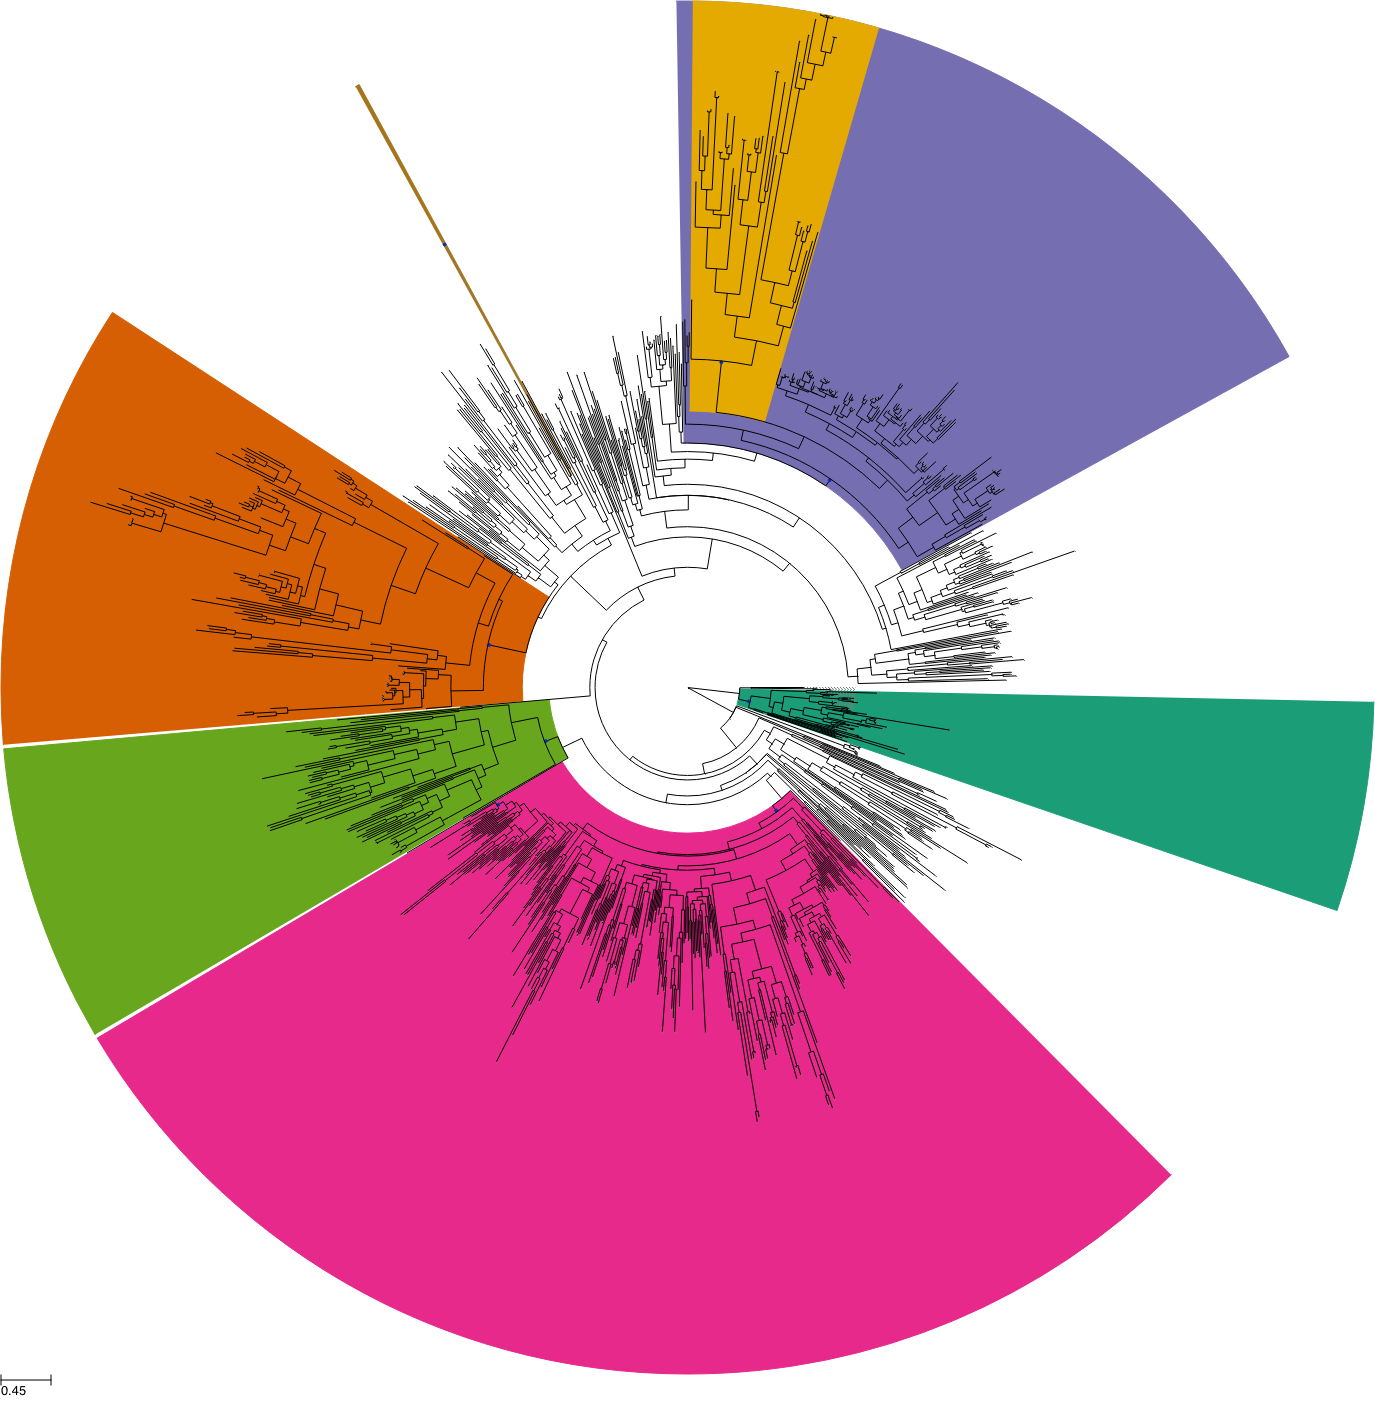

In [10]:

for subgroup in styles.keys():
    if subgroup != 'default' and subgroup != 'TaA':
        raxml.get_common_ancestor([l for l in raxml.iter_leaves() if l.known_type==subgroup]).set_style(styles[subgroup])
    if subgroup == 'TaA':
        [l for l in raxml.iter_leaves() if l.known_type=='TaA'][0].set_style(styles['TaA'])

raxml.render("big_curated.einsi.trim.raxml.subtypes.pdf", tree_style=ts)        
raxml.render("%%inline", tree_style=ts)

<p style="background-color:#a1c9ff;">Deltaproteobacteria</p>
<p style="background-color:#a6d854;">Spirochaetes</p>
<p style="background-color:#b3b3b3;">Other</p>
<p style="background-color:#fc8d62;">Firmicutes</p>
<p style="background-color:#0096ef;">Gammaproteobacteria</p>
<p style="background-color:#66c2a5;">Bacteroidetes</p>
<p style="background-color:#e5c494;">Tenericutes</p>
<p style="background-color:#00629f;">Betaproteobacteria</p>
<p style="background-color:#003355;">Alphaproteobacteria</p>
<p style="background-color:#ffd92f;">Archaea</p>
<p style="background-color:#e78ac3;">Actinobacteria</p>



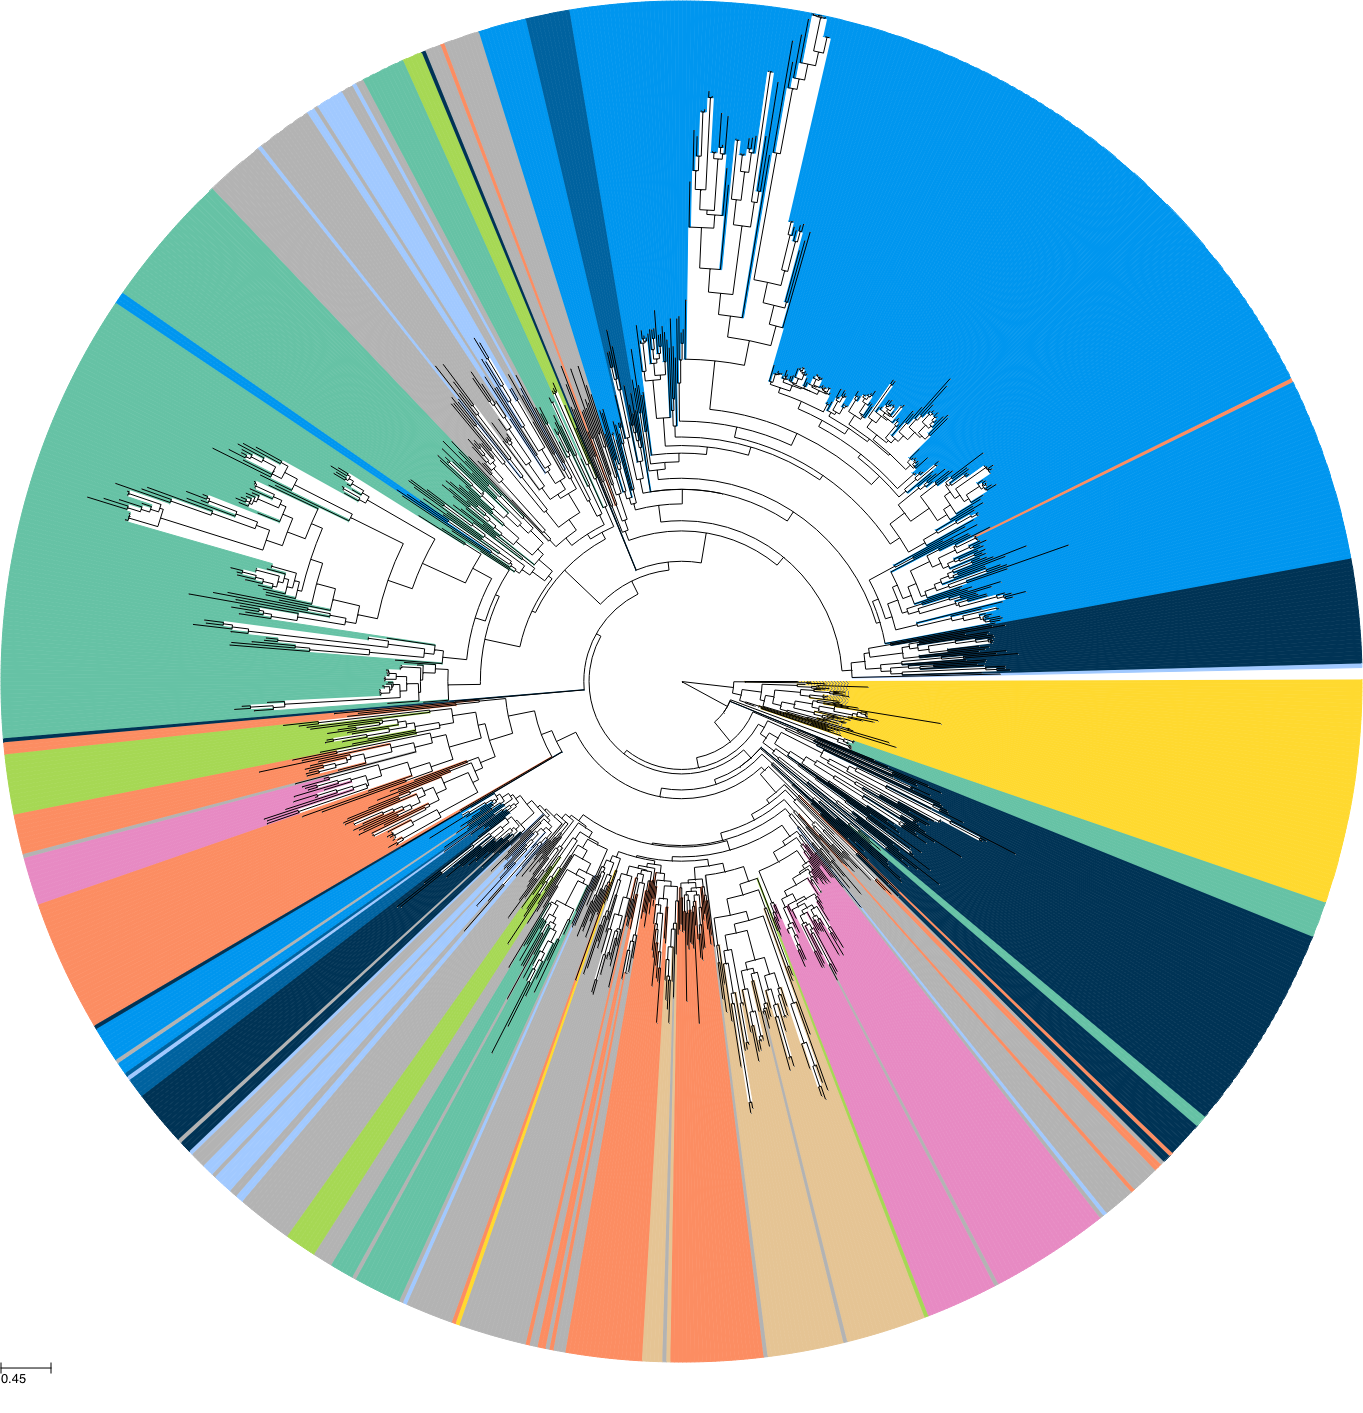

In [11]:
reset_tree_style(raxml)

colored_taxa = {
    'Alphaproteobacteria': '#003355',
    'Betaproteobacteria': '#00629f',
    'Gammaproteobacteria': '#0096ef',
    'Deltaproteobacteria': '#a1c9ff',
    'Bacteroidetes': '#66c2a5',
    'Firmicutes': '#fc8d62',
    'Actinobacteria': '#e78ac3',
    'Spirochaetes': '#a6d854',
    'Archaea': '#ffd92f',
    'Tenericutes': '#e5c494',
    'Other': '#b3b3b3',    
}
taxa_styles = {k: ete3.NodeStyle() for k in colored_taxa.keys()}
for k, v in colored_taxa.items():
    taxa_styles[k]['bgcolor'] = v
    taxa_styles[k]['size'] = 0

for leaf in raxml.iter_leaves():
    if leaf.rel_taxa in taxa_styles:
        leaf.set_style(taxa_styles[leaf.rel_taxa])
    else:
        leaf.set_style(taxa_styles['Other'])

html = ''
for taxa, color in colored_taxa.items():
    html+='<p style="background-color:{};">{}</p>\n'.format(color, taxa)
print(html)

raxml.render("big_curated.einsi.trim.raxml.taxa.pdf", tree_style=ts) 
raxml.render("%%inline", tree_style=ts)





<p style="background-color:#66c2a5;">Bacteroidetes</p>
<p style="background-color:#ffd92f;">Archaea</p>
<p style="background-color:#a1c9ff;">Deltaproteobacteria</p>
<p style="background-color:#fc8d62;">Firmicutes</p>
<p style="background-color:#0096ef;">Gammaproteobacteria</p>
<p style="background-color:#00629f;">Betaproteobacteria</p>
<p style="background-color:#e5c494;">Tenericutes</p>
<p style="background-color:#003355;">Alphaproteobacteria</p>
<p style="background-color:#b3b3b3;">Other</p>
<p style="background-color:#e78ac3;">Actinobacteria</p>
<p style="background-color:#a6d854;">Spirochaetes</p>

In [12]:
#raxml.show(tree_style=ts)

In [13]:
alphas = ['D0D588', 'D8JQ47', 'E2CGR7', 'C3MAS1']
taas = ['I4C7Y0', 'Q8KER2']
upxys = ['A6LE17']

def keep(name):
    return name in alphas or name in taas or name in upxys


In [14]:
mini_raxml = raxml.copy()
reset_tree_style(mini_raxml)
for leaf in mini_raxml.get_leaves():
    if not '_' in leaf.name and not keep(leaf.name):
        leaf.delete(preserve_branch_length=True)

for subgroup in styles.keys():
    if subgroup != 'default' and subgroup != 'TaA':
        mini_raxml.get_common_ancestor([l for l in mini_raxml.iter_leaves() if l.known_type==subgroup]).set_style(styles[subgroup])
    if subgroup == 'TaA':
        [l for l in mini_raxml.iter_leaves() if l.known_type=='TaA'][0].set_style(styles['TaA'])
        
mini_ts = ete3.TreeStyle()
mini_ts.show_branch_support = True

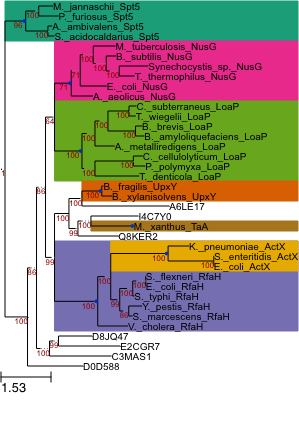

In [15]:
mini_raxml.render('%%inline', tree_style=mini_ts)


In [16]:

Entrez.email = 'jgoodson@umd.edu'
e = JEntrez('jgoodson@umd.edu', '/Volumes/Space/gbk')

def get_source_seq(protein):
    embl = [xref.split(':')[1] for xref in protein.dbxrefs if 'EMBL' in xref][-1]
    genome = e.getGenome(embl)
    protein_seq = str(protein.seq)
    for feature in genome.features:
        if feature.type == 'CDS' and 'translation' in feature.qualifiers and feature.qualifiers['translation'][0] == protein_seq:
            break
    else:
        print('Feature not found {}'.format(protein.id))
        return False
    return genome, feature

def get_clusters(acc):
    try:
        with open('/Volumes/Space/gbk/antismash_results/{}/geneclusters.js'.format(acc)) as cluster_js:
            js = cluster_js.read()
            start = js.index('{')
            end = js.rindex(';\nvar details_data')
            return json.loads(js[start:end])
    except FileNotFoundError:
        return None

@RedisMemo
def overlaps(p, distance=10000):
    ss = get_source_seq(p)
    if ss:
        genome, feature = ss
    else:
        return 0, False, True
    clusters = get_clusters(genome.id)
    feature_location = (feature.location.start + feature.location.end) / 2
    at_edge = feature_location < 5000 or feature_location > (len(genome)-5000)
    if not clusters:
        return feature_location, None, at_edge
    for cluster_name, cluster in clusters.items():
        if (cluster['end']+distance) > feature_location > (cluster['start']-distance):
            return feature_location, cluster, at_edge
    return feature_location, None, at_edge

In [17]:

bar = progressbar.ProgressBar(max_value=len(list(raxml.iter_leaves())))
for leaf in bar(raxml.iter_leaves()):
    leaf.location, leaf.cluster, leaf.at_contig = overlaps(leaf.p, 10000)

 21% ( 229 of 1052) |############                                             | Elapsed Time: 0:03:02 ETA:  0:01:39

Feature not found P36260
Feature not found P47300

 27% ( 293 of 1052) |###############                                          | Elapsed Time: 0:03:37 ETA:  0:07:58


Feature not found P36265

 99% (1051 of 1052) |######################################################## | Elapsed Time: 0:14:24 ETA:  0:00:00

100% (1052 of 1052) |#########################################################| Elapsed Time: 0:14:24 Time: 0:14:24


<p style="background-color:#ffd92f;">other</p>
<p style="background-color:#fc8d62;">saccharide</p>
<p style="background-color:#00629f;">specialized</p>



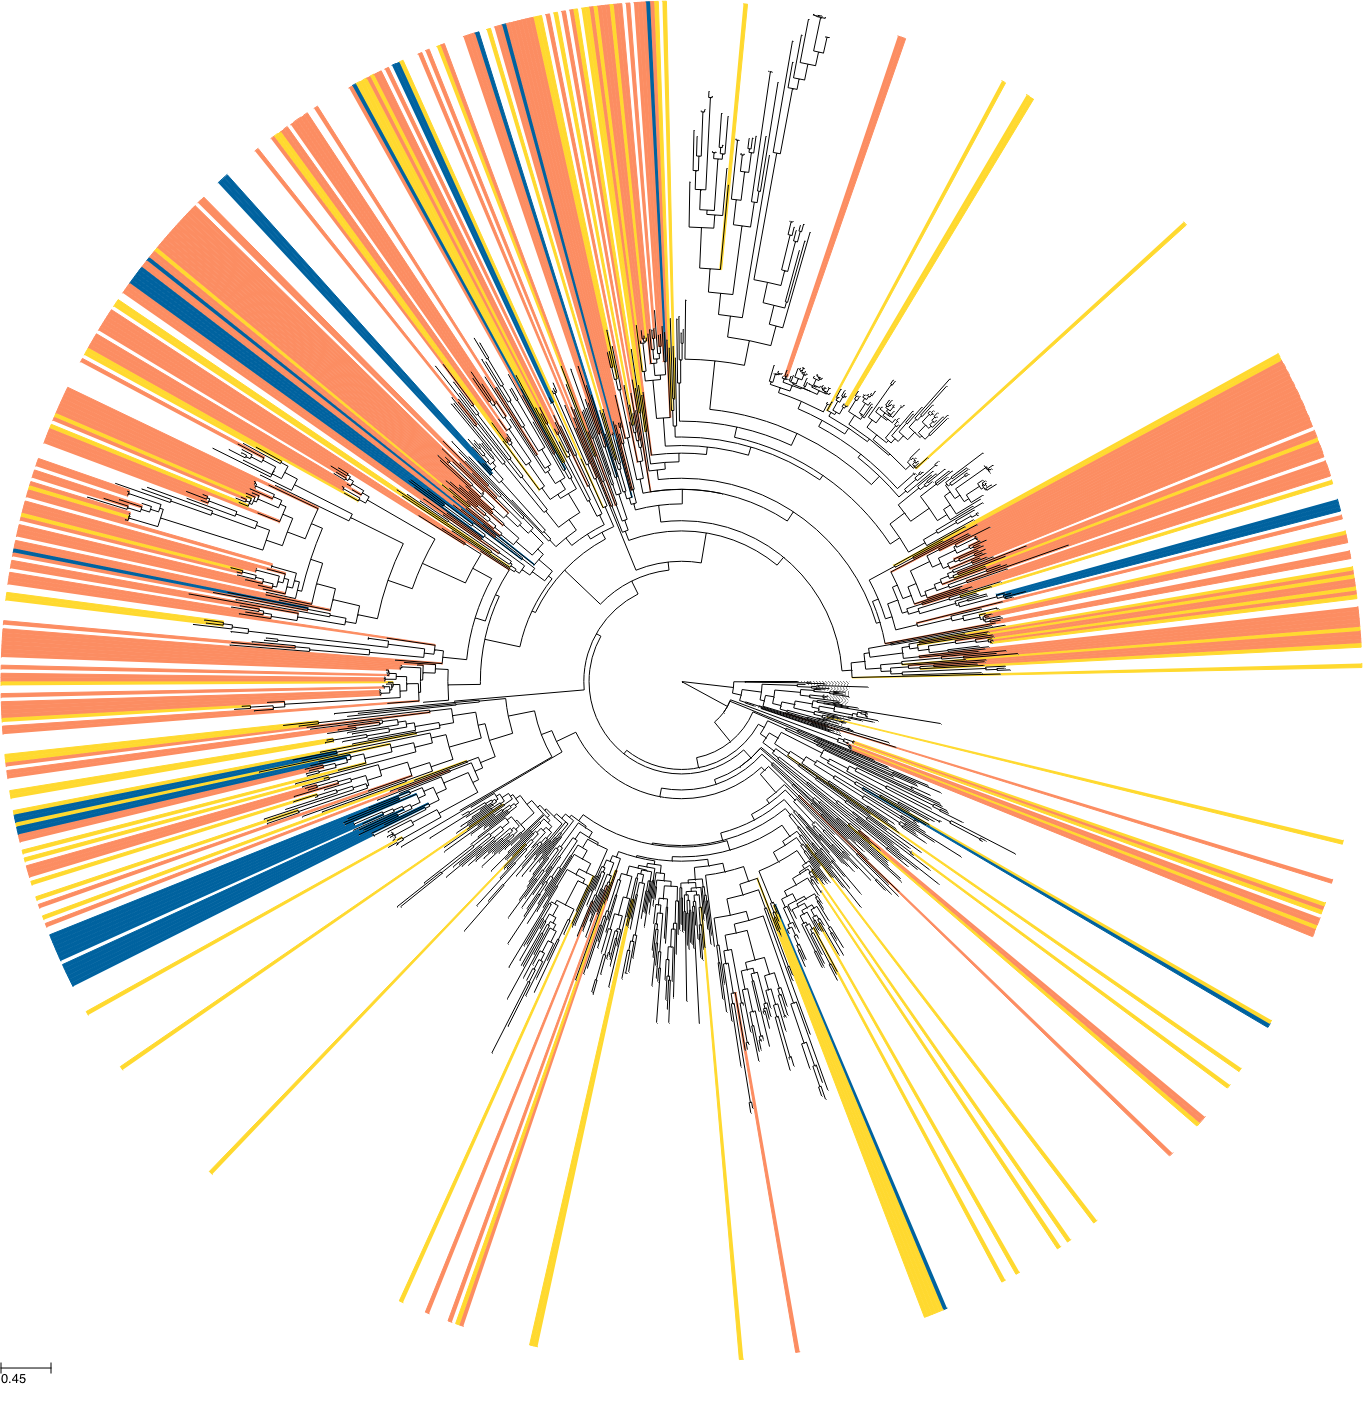

In [18]:
reset_tree_style(raxml)
colored_clusts = {
    'specialized': '#00629f',
    'saccharide': '#fc8d62',
    'other': '#ffd92f',
}
cluster_types = set()
for leaf in raxml.iter_leaves():
    if leaf.cluster:
        t = leaf.cluster['type']
        cluster_types.add(t)
        if ('ks' in t or 'nrps' in t or 'terpene' in t):
            leaf.ctype = 'specialized'
        elif 'saccharide' in t:
            leaf.ctype = 'saccharide'
        else:
            leaf.ctype = 'other'
        leaf.specific_ctype = t
    else:
        leaf.ctype = None
        leaf.specific_ctype = None

clust_styles = {k: ete3.NodeStyle() for k in colored_clusts.keys()}
for k, v in colored_clusts.items():
    clust_styles[k]['bgcolor'] = v
    clust_styles[k]['size'] = 0

for leaf in raxml.iter_leaves():
    if leaf.ctype in clust_styles:
        leaf.set_style(clust_styles[leaf.ctype])

html = ''
for clust, color in colored_clusts.items():
    html+='<p style="background-color:{};">{}</p>\n'.format(color, clust)
print(html)

raxml.render("big_curated.einsi.trim.raxml.association.pdf", tree_style=ts) 
raxml.render("%%inline", tree_style=ts)


<p style="background-color:#fc8d62;">saccharide</p>
<p style="background-color:#00629f;">specialized</p>
<p style="background-color:#ffd92f;">other</p>

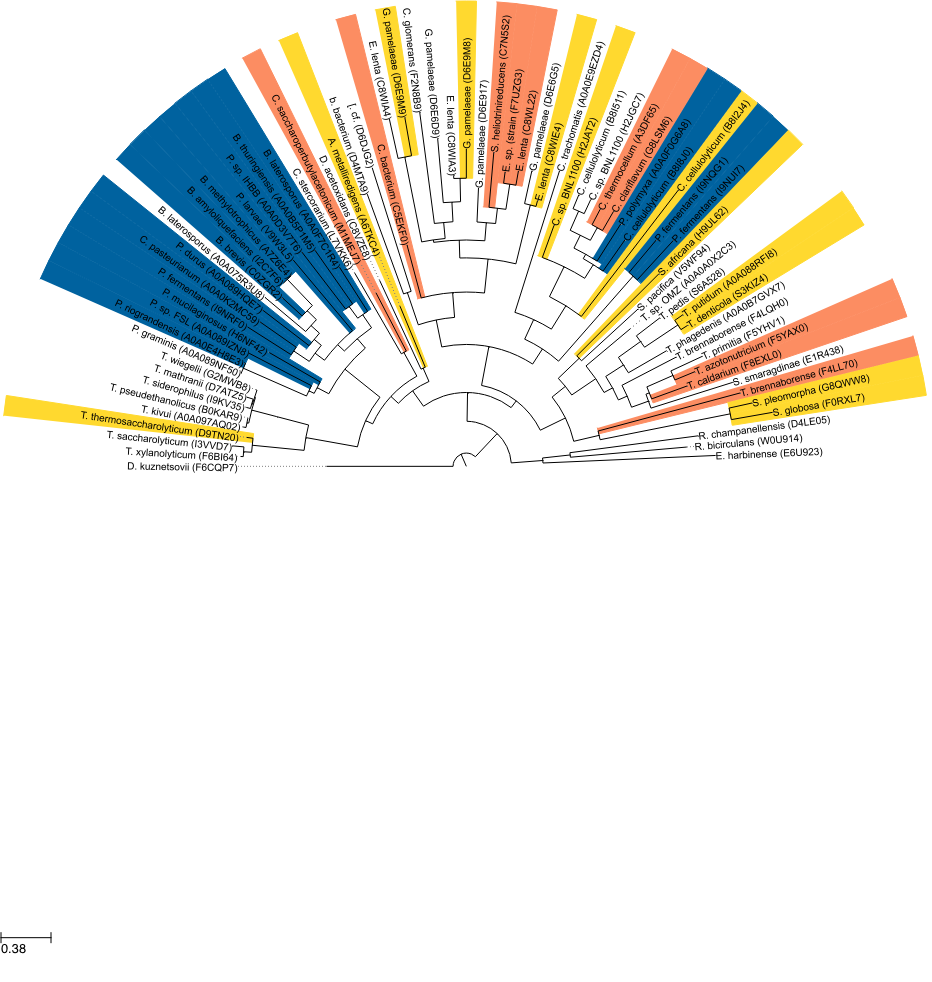

In [19]:
loap_style = ete3.TreeStyle()
loap_style.mode = 'c'
loap_style.arc_start = 180
loap_style.arc_span = 180

at_contig_style = ete3.NodeStyle()
at_contig_style['bgcolor'] = 'lightgrey'
def shorten(species):
    return ' '.join([part[0]+'.' if not i else part for i, part in enumerate(species.split(' '))])

loap_subtree = raxml.get_common_ancestor([l for l in raxml.iter_leaves() if l.known_type=='LoaP']).copy()
for leaf in loap_subtree.iter_leaves():
    leaf.name = '{} ({})'.format(shorten(leaf.species), leaf.uniprot_acc)
    if leaf.at_contig and not leaf.ctype:
        leaf.detach()
loap_subtree.render('LoaP subtree.pdf', tree_style=loap_style)
#loap_style.arc_start = 270
#loap_subtree.render('LoaP subtree_v.pdf', tree_style=loap_style)
loap_subtree.render('%%inline', tree_style=loap_style)

In [20]:
for leaf in loap_subtree.iter_leaves():
    print(leaf.uniprot_acc, leaf.species, leaf.ctype, leaf.specific_ctype)

F6CQP7 Desulfotomaculum kuznetsovii None None
F6BI64 Thermoanaerobacterium xylanolyticum None None
I3VVD7 Thermoanaerobacterium saccharolyticum None None
D9TN20 Thermoanaerobacterium thermosaccharolyticum other cf_putative
A0A097AQ02 Thermoanaerobacter kivui None None
B0KAR9 Thermoanaerobacter pseudethanolicus None None
I9KV35 Thermoanaerobacter siderophilus None None
D7ATZ5 Thermoanaerobacter mathranii None None
G2MWB8 Thermoanaerobacter wiegelii None None
A0A089NF50 Paenibacillus graminis None None
A0A0E4H8E3 Paenibacillus riograndensis specialized nrps-t1pks-transatpks
A0A089IZN8 Paenibacillus sp. FSL specialized transatpks
H6NF42 Paenibacillus mucilaginosus specialized transatpks
I9NRF0 Pelosinus fermentans specialized nrps
A0A0K2MC59 Clostridium pasteurianum specialized otherks
A0A089HQE7 Paenibacillus durus specialized otherks-transatpks
A0A075R3U8 Brevibacillus laterosporus None None
C0ZGR2 Brevibacillus brevis specialized nrps-transatpks
I2C7F6 Bacillus amyloliquefaciens specia

In [21]:
import pandas


In [22]:
raxml_named = ete3.Tree('3daligns/expresso/RAxML_bipartitions.named_comb.tcs_weighted.trim.raxml')
for leaf in raxml_named.iter_leaves():
    for k in named.keys():
        if leaf.name==k[:len(leaf.name)]:
            leaf.name = k
        if '_' in leaf.name:
            leaf.known_type = leaf.name.split('_')[-1]
        else:
            leaf.known_type = manual_assignments[leaf.name]
            

            
raxml_named.render("%%inline", tree_style=mini_ts)
spt5 = raxml_named.get_common_ancestor([l for l in raxml_named.iter_leaves() if 'Spt5' in l.name])
raxml_named.set_outgroup(spt5)
for subgroup in styles.keys():
    if subgroup != 'default':
        raxml_named.get_common_ancestor([l for l in raxml_named.iter_leaves() if l.known_type==subgroup]).set_style(styles[subgroup])

            
for leaf in raxml_named.iter_leaves():
    leaf.acc = named[leaf.name]
    leaf.name = ' '.join(leaf.name.split('_')[:2])+' ({})'.format(leaf.acc)
    


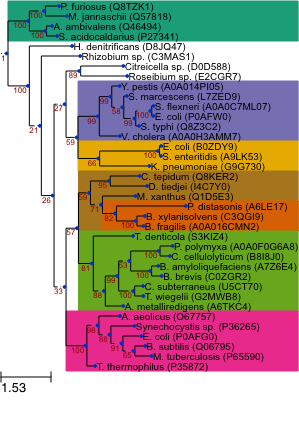

In [23]:
raxml_named.render("3daligns/expresso/RAxML_bestTree.named_comb.tcs_weighted.trim.raxml.pdf", tree_style=mini_ts)
raxml_named.render("%%inline", tree_style=mini_ts)

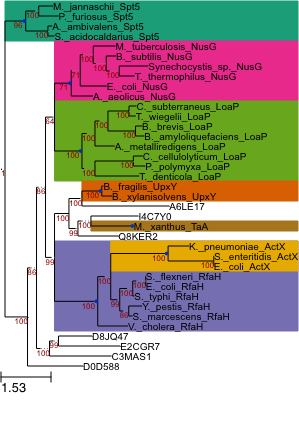

In [24]:
mini_raxml.render('%%inline', tree_style=mini_ts)

In [30]:
mini_raxml2 = raxml.copy()

for leaf in mini_raxml2.get_leaves():
    if not '_' in leaf.name and not keep(leaf.name):
        leaf.delete(preserve_branch_length=True)
reset_tree_style(mini_raxml2)

for subgroup in styles.keys():
    if subgroup != 'default' and subgroup != 'TaA':
        mini_raxml2.get_common_ancestor([l for l in mini_raxml2.iter_leaves() if l.known_type==subgroup]).set_style(styles[subgroup])
    if subgroup == 'TaA':
        [l for l in mini_raxml2.iter_leaves() if l.known_type=='TaA'][0].set_style(styles['TaA'])


In [59]:
for l in mini_raxml2.get_leaves():
    l.name = '{} ({})'.format(shorten(l.species), l.p.id)
mini_raxml2.get_leaves()[33] = 'S. sp. Kazuza'
mini_raxml2.get_leaves()[7] = 'R. sp. strain NGR234'

reset_tree_style(mini_raxml2)
#mini_raxml2.show(tree_style=mini_ts)

In [60]:
mini_raxml2.render('mini_raxml_matching.pdf', tree_style=mini_ts)

{'faces': [[94.9059406581269,
   131.0,
   206.9059406581269,
   141.0,
   29,
   'S. marcescens (L7ZED9)'],
  [75.81686309030721, 351.0, 150.8168630903072, 361.0, 71, 'E. coli (P0AFG0)'],
  [104.5263148410581,
   121.0,
   206.52631484105808,
   131.0,
   28,
   'Y. pestis (A0A014PI05)'],
  [96.3672514802337,
   241.0,
   192.3672514802337,
   251.0,
   52,
   'T. wiegelii (G2MWB8)'],
  [95.18881813313419,
   191.0,
   192.1888181331342,
   201.0,
   40,
   'C. tepidum (Q8KER2)'],
  [64.77056028413425,
   321.0,
   152.77056028413426,
   331.0,
   67,
   'B. subtilis (Q06795)'],
  [87.52665954950108,
   331.0,
   187.52665954950106,
   341.0,
   69,
   'S. sp. (strain (P36265)'],
  [98.54863309301938,
   91.0,
   214.54863309301936,
   101.0,
   24,
   'S. flexneri (A0A0C7ML07)'],
  [180.7930280643591, 151.0, 254.7930280643591, 161.0, 33, 'E. coli (B0ZDY9)'],
  [73.85874599866251,
   341.0,
   184.85874599866253,
   351.0,
   70,
   'T. thermophilus (P35872)'],
  [47.58475060423792,
 